# CEBRA

cebra is a method to use time information, to label behavior variables either 'near' or 'far', and use contrastive learning to train for an embedding.
the embedding will be a nice visualization of neural maniford, and provide the behavior variable mapping in neural (embedding) space.

# imports

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
# import 
import numpy as np
import cebra
from cebra import CEBRA
import pandas as pd
import tempfile
from pathlib import Path
import sys
import os
import pickle
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)
from notification import notify

# load neural and behavior data

In [6]:
# fake data test
# timesteps = 50000
# neurons = 50
# out_dim = 3

# neural_data = np.random.normal(0,1,(timesteps, neurons))
# continuous_label = np.random.normal(0,1,(timesteps, 3))
# discrete_label = np.random.randint(0,10,(timesteps,2))
# neural_data.shape, continuous_label.shape, discrete_label.shape

((50000, 50), (50000, 3), (50000, 2))

In [25]:
# use my data
with open(f'{workdir}/test/neural/cebra/test','rb') as f:
    (neural_data,continuous_label)=pickle.load(f)
neural_data.shape, continuous_label.shape

((18985, 94), (18985, 13))

# init model and train

In [21]:
timesteps = neural_data.shape[0]
neurons = neural_data.shape[1]
out_dim = 3
max_iterations=5*3600 # 1 hr training per fit
time_offsets=4 # 0.1 s

single_cebra_model = CEBRA(model_architecture='offset10-model',
                        batch_size=None, # whole dataset
                        learning_rate=0.005,
                        # temperature_mode="auto",
                        temperature=1,
                        output_dimension=out_dim,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda:0',
                        verbose=True,
                        time_offsets=time_offsets)

# single_cebra_model.fit(neural_data, continuous_label[:,[0,2,4,6,12,]])
# embedding = single_cebra_model.transform(neural_data)
# assert(embedding.shape == (timesteps, out_dim))
# notify('cebra ready')

In [22]:
# further training
for i in np.arange(2):
    single_cebra_model.fit(neural_data, continuous_label[:,[0,2,4,6,12,]])
    tmp_file = Path(f'{workdir}/test/neural/cebra/', f'cebra024612_0309fast_{i+1}hr.pt')
    single_cebra_model.save(tmp_file)
    
    notify(f'cebra {i} ready')

  0%|                                                         | 0/18000 [00:00<?, ?it/s]

pos: -0.7376 neg:  10.0301 total:  9.2925 temperature:  1.0000: 100%|█| 18000/18000 [58:
pos: -0.7431 neg:  10.0303 total:  9.2872 temperature:  1.0000: 100%|█| 18000/18000 [58:


# save and load

In [26]:
# save and load

# tmp_file = Path(f'{workdir}/test/neural/cebra/', 'cebra3hr024612.pt')
# single_cebra_model.save(tmp_file)



# # New session: load and use the model
single_cebra_model = cebra.CEBRA.load(f'{workdir}/test/neural/cebra/cebra024612_0309fast_2hr.pt')


Text(0.5, 1.0, 'training loss')

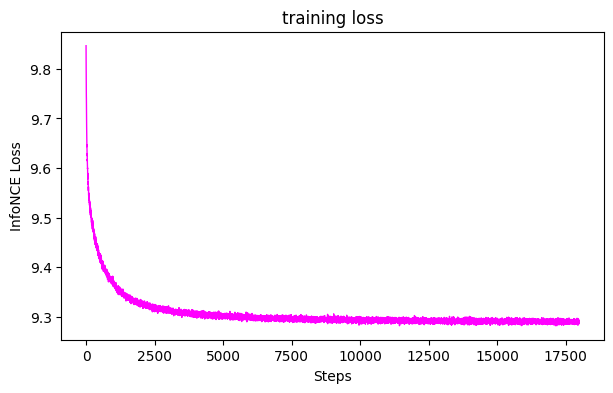

In [27]:
%matplotlib inline

ax=cebra.plot_loss(single_cebra_model)
ax.set_title('training loss')

# ax=cebra.plot_temperature(single_cebra_model)
# ax.set_title('temperature')


# analysis

thinking:
    the trained embedding shows a contrast low high value region for the task variables. including eye and belief.
    our goal is to better understand eye and belief. which part of them are simlar, which part are different.
    looking at the embedding, they show slightly different polar. in other words, they are 'shifted'. 
    if we think about this shift in vector or direction, they share a common direction (they project on that direction) and have distinct othognal component (thats the part they differ).
    if we can map the colorbar on to the embedding, or summarize the embedding sphere with a path, we can compare the path to see the difference. but still, we dont know what is a shared part path, what is individual compomnent path. (even that, could be a nice thing to plot)

plot: embedding in 3d
    its a sphere. we found some c shape structure emerge in training. this is expected.
    
plot: embedding diff in 3d
    we can color the scatter by diff of two variables. belief - eye. 
    but the unit are different. eg, belief heading cannnot be compared to eye directly. we can do 
    and hard to understand whats going on.
    res: seems there is some structure or pattern.

plot: embedding in 2d.
    similar results.

plot: embedding in 2d, connected by time
    this is a trial in embedding space. for smoother changing variables, eg, heading angle, this should be relatively smooth.
    res, somewhat smooth.


In [29]:
embedding = single_cebra_model.transform(neural_data)

## plot functions

In [70]:
from matplotlib import pyplot as plt

def plot_embedding_contrast(ax, embedding, label, gray = False, beh_idx=(0,1), idx_order = (0,1,2)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx[0]]-label[:, beh_idx[1]]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               embedding [:,idx3],
               c=r_c,
            #    vmin=0,
            #    vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.zaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.set_zlabel('dim 3')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.axis('equal')
    return ax

def plot_embedding(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1,2)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               embedding [:,idx3],
               c=r_c,
               vmin=0,
               vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.zaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.set_zlabel('dim 3')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.axis('equal')
    return ax

def plot_embedding2d(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               c=r_c,
               vmin=0,
               vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.axis('equal')
    return ax

## 3d embedding

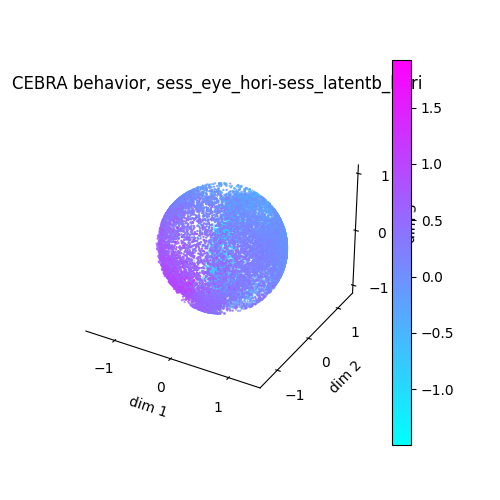

In [69]:

%matplotlib widget

fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, projection='3d')
ax1=plot_embedding_contrast(ax1, embedding, continuous_label, beh_idx=[2,4])

thisyname=[
    'sess_latentff_hori',
    'sess_latentff_vert',
    'sess_eye_hori',
    'sess_eye_vert',
    'sess_latentb_hori',
    'sess_latentb_vert',
    '(sess_angle_from_start)',
    ('sess_ll_t'),
    ('sess_t'),
    ('sess_err'),
    ('sess_err_belief'),
    ('sess_angle_from_start_belief'),
    (('belief_heading')), # belief heading
]

ax1.set_title(f'CEBRA behavior, {thisyname[2]}-{thisyname[4]}')

plt.show()

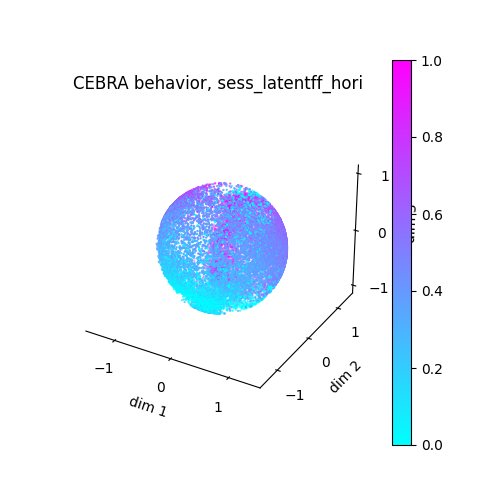

In [31]:
beh_idx    =      0


%matplotlib widget
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, projection='3d')
ax1=plot_embedding(ax1, embedding, continuous_label, beh_idx=beh_idx)

thisyname=[
    'sess_latentff_hori',
    'sess_latentff_vert',
    'sess_eye_hori',
    'sess_eye_vert',
    'sess_latentb_hori',
    'sess_latentb_vert',
    '(sess_angle_from_start)',
    ('sess_ll_t'),
    ('sess_t'),
    ('sess_err'),
    ('sess_err_belief'),
    ('sess_angle_from_start_belief'),
    (('belief_heading')), # belief heading
]

ax1.set_title(f'CEBRA behavior, {thisyname[beh_idx]}')
plt.show()


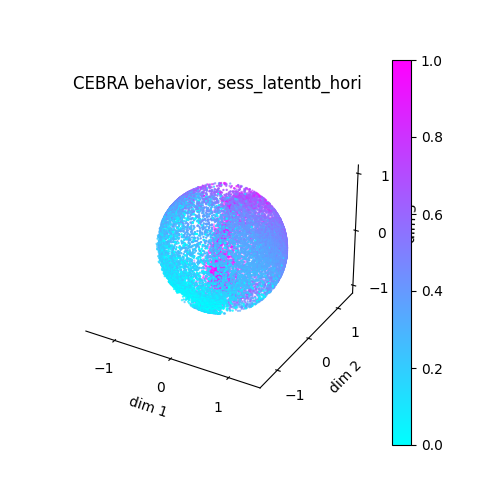

In [107]:
beh_idx    =      4
%matplotlib widget
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, projection='3d')
ax1=plot_embedding(ax1, embedding, continuous_label, beh_idx=beh_idx)


ax1.set_title(f'CEBRA behavior, {thisyname[4]}')

plt.show()


## 2d embedding

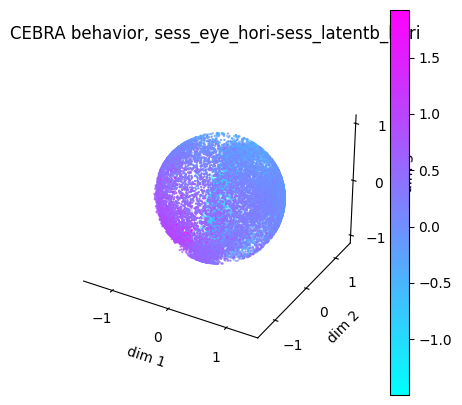

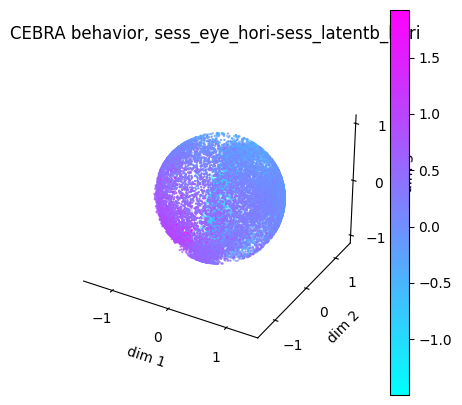

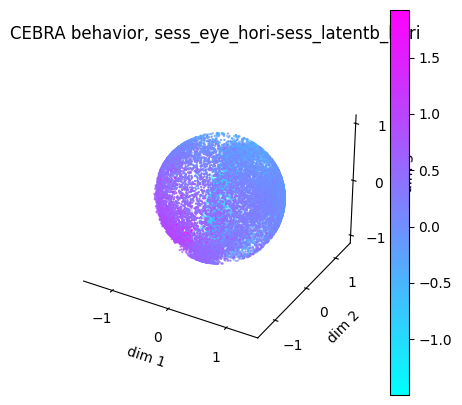

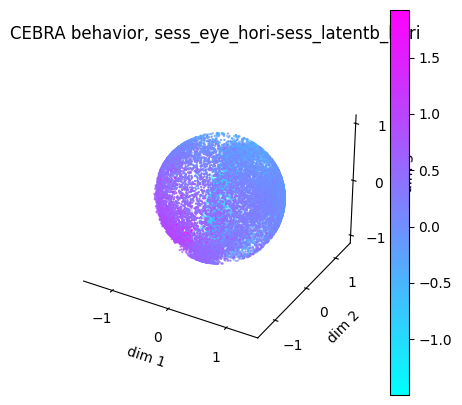

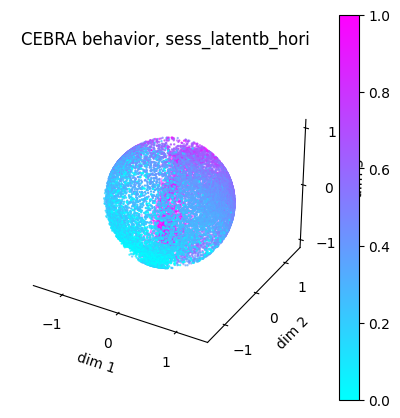

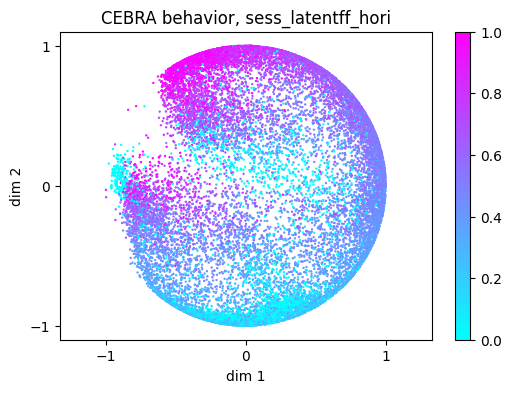

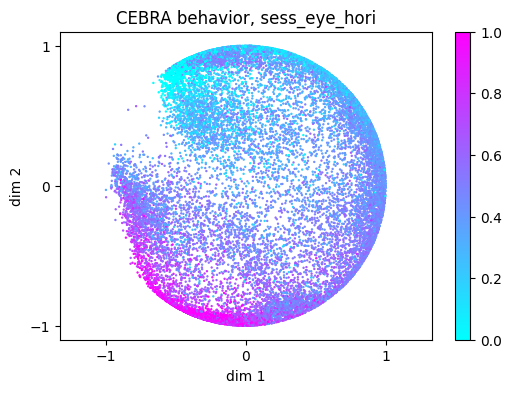

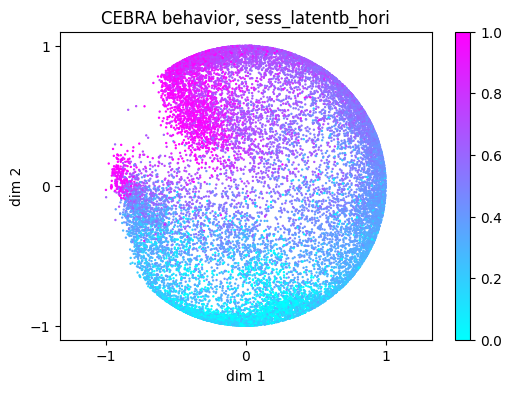

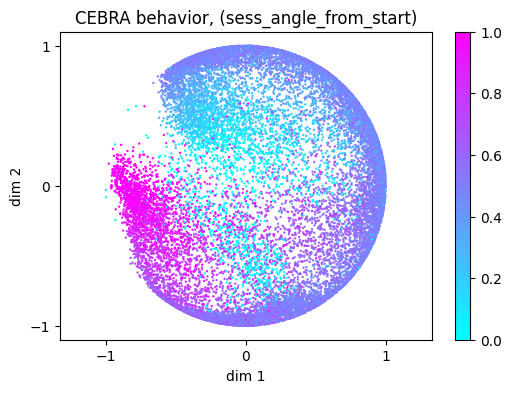

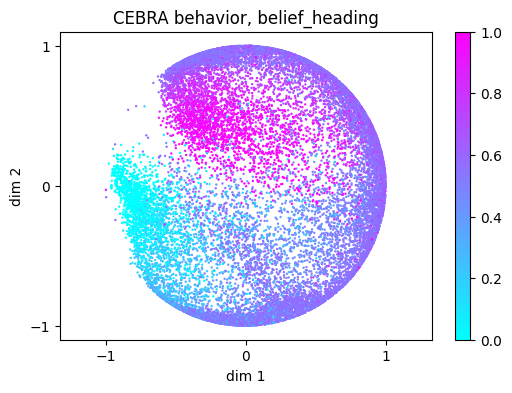

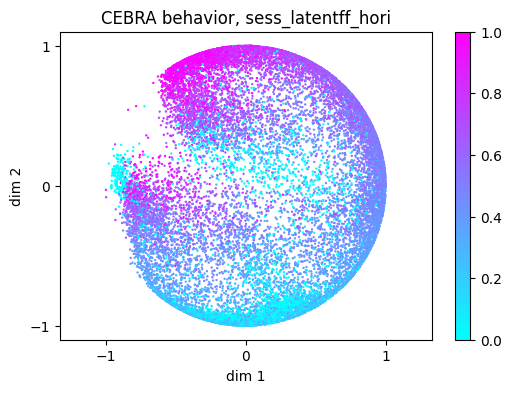

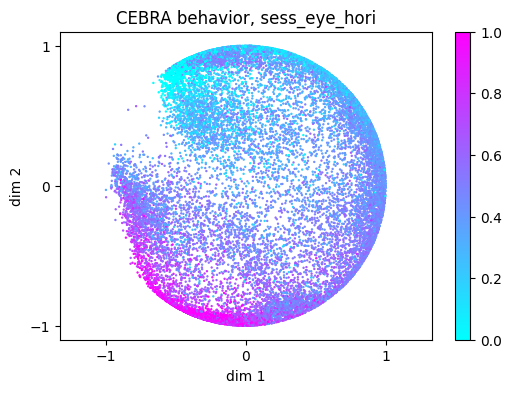

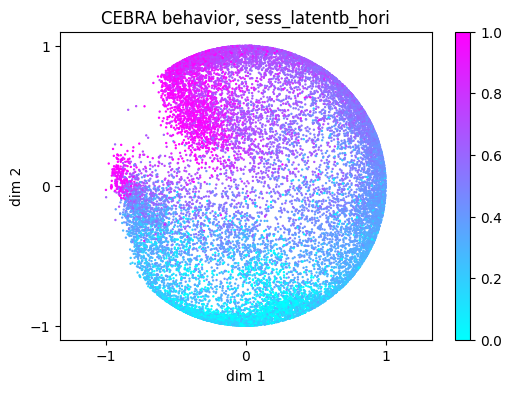

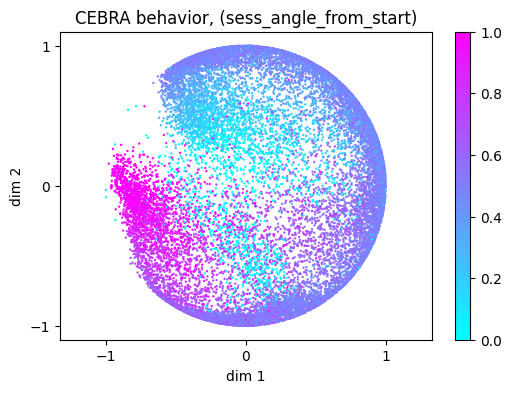

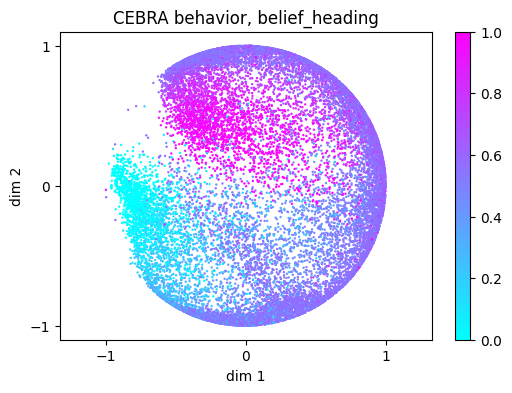

In [73]:
%matplotlib inline

for beh_idx in [0,2,4,6,12]:
    
    fig = plt.figure(figsize=(6,4))
    ax1 = plt.subplot(111)
    ax1=plot_embedding2d(ax1, embedding, continuous_label, beh_idx=beh_idx)

    ax1.set_title(f'CEBRA behavior, {thisyname[beh_idx]}')

    plt.show()

## 2d embedding, trajectory

Text(0.5, 1.0, 'CEBRA behavior, belief_heading')

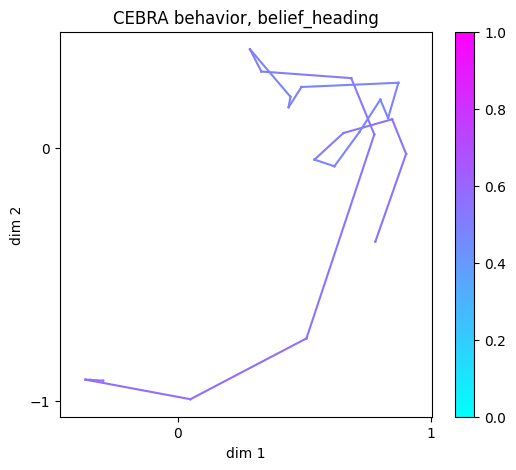

In [60]:
# a trajectory (connect time) in latent space
def plot_embedding2d_traj(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    
    idx1, idx2 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               c=r_c,
               vmin=0,
               vmax=1,
               cmap=r_cmap, s=0.5)
    x,y=embedding [:,idx1],embedding [:,idx2]
    for i in range(len(x) - 1):
        ax.plot([x[i], x[i+1]], [y[i], y[i+1]], c=plt.cm.cool(r_c[i]))
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.axis('equal')
    return ax


beh_idx=12
%matplotlib inline
fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(111)
ax1=plot_embedding2d_traj(ax1, embedding[:22], continuous_label[:22], beh_idx=beh_idx)
ax1.set_title(f'CEBRA behavior, {thisyname[beh_idx]}')


## plot: 2d embedding contrast



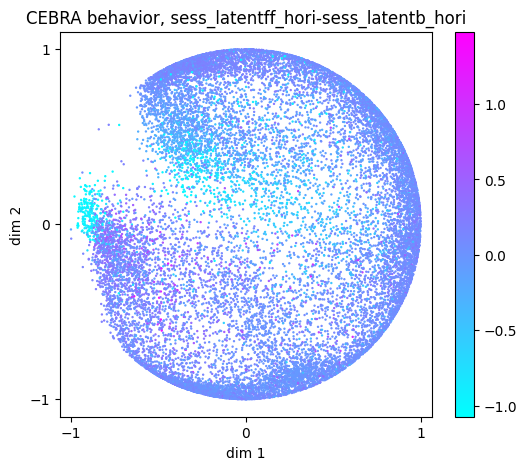

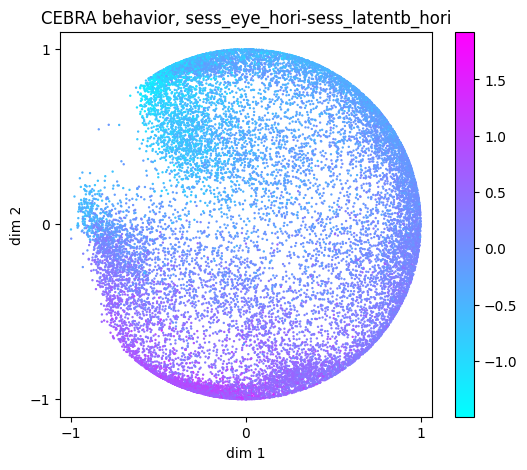

In [81]:
def plot_embedding2d_contrast(ax, embedding, label, gray = False, beh_idx=(0,1), idx_order = (0,1,2)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx[0]]-label[:, beh_idx[1]]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               c=r_c,
            #    vmin=0,
            #    vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.axis('equal')
    return ax


%matplotlib inline
var1, var2=0,4 # color using var1 - var2
fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(111)
ax1=plot_embedding2d_contrast(ax1, embedding, continuous_label, beh_idx=[var1, var2])
ax1.set_title(f'CEBRA behavior, {thisyname[var1]}-{thisyname[var2]}')
plt.show()

var1, var2=2,4 # color using var1 - var2
fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(111)
ax1=plot_embedding2d_contrast(ax1, embedding, continuous_label, beh_idx=[var1, var2])
ax1.set_title(f'CEBRA behavior, {thisyname[var1]}-{thisyname[var2]}')
plt.show()


## asdf

# other analysis

In [ ]:
# try full latent dim, and plot individual latent space

In [ ]:
# subtraction, make sure unit are corect

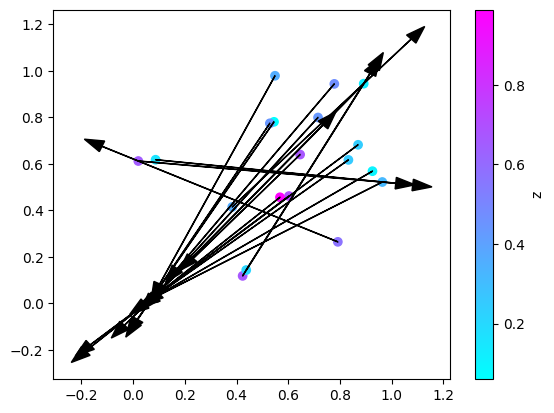

In [106]:
import matplotlib.pyplot as plt
import numpy as np

def compute_arrow_direction(x, y, z, n):
    directions = []
    for i in range(len(x)):
        distances = np.sqrt((x - x[i])**2 + (y - y[i])**2)
        nearest_indices = np.argsort(distances)[:n]  # Indices of the nearest n points
        dx = np.mean(np.diff(x[nearest_indices]))
        dy = np.mean(np.diff(y[nearest_indices]))
        dz = np.mean(np.diff(z[nearest_indices]))
        angles = np.arctan2(dy, dx)
        directions.append(angles)
    return directions

# Generate some random data
np.random.seed(0)
x = np.random.rand(20)
y = np.random.rand(20)
z = np.random.rand(20)  # z values

# Create a scatter plot
plt.scatter(x, y, c=z, cmap='cool')

# Compute the average direction using the nearest n scatter points
n = 20  # Number of nearest points
avg_angles = compute_arrow_direction(x, y, z, n)

# Plot the average arrow flow plot
for i in range(len(x)):
    plt.arrow(x[i], y[i], np.cos(avg_angles[i]), np.sin(avg_angles[i]), head_width=0.05, color='black')

plt.colorbar(label='z')  # Add colorbar for reference
plt.show()


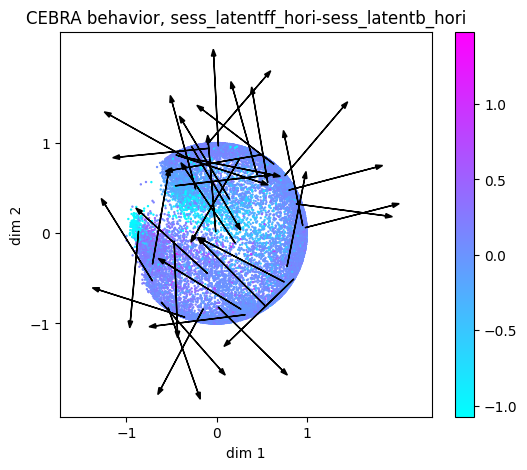

In [109]:
def plot_embedding2d_contrast(ax, embedding, label, gray = False, beh_idx=(0,1), idx_order = (0,1,2),n=20):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx[0]]-label[:, beh_idx[1]]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               c=r_c,
            #    vmin=0,
            #    vmax=1,
               cmap=r_cmap, s=0.5)



    # Create a scatter plot
    x,y,z=embedding [:,idx1],embedding [:,idx2],r_c
    # Compute the average direction using the nearest n scatter points
    # n:  Number of nearest points
    avg_angles = compute_arrow_direction(x, y, z, n)
    # Plot the average arrow flow plot
    for i in range(len(x)):
        if not i%500:
            plt.arrow(x[i], y[i], np.cos(avg_angles[i]), np.sin(avg_angles[i]), head_width=0.05, color='black')


    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.axis('equal')
    return ax


%matplotlib inline
var1, var2=0,4 # color using var1 - var2
fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(111)
ax1=plot_embedding2d_contrast(ax1, embedding, continuous_label, beh_idx=[var1, var2])
ax1.set_title(f'CEBRA behavior, {thisyname[var1]}-{thisyname[var2]}')
plt.show()

# var1, var2=2,4 # color using var1 - var2
# fig = plt.figure(figsize=(6,5))
# ax1 = plt.subplot(111)
# ax1=plot_embedding2d_contrast(ax1, embedding, continuous_label, beh_idx=[var1, var2])
# ax1.set_title(f'CEBRA behavior, {thisyname[var1]}-{thisyname[var2]}')
# plt.show()


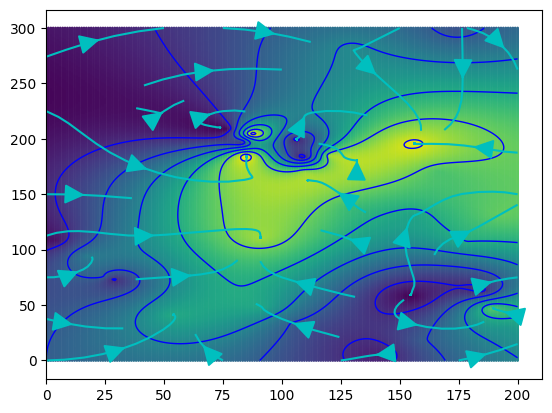

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# Generate data
np.random.seed(0)
width, height = 200, 300
x, y, z = np.random.random((3,33))
x *= width
y *= height

#create a grid on which to interpolate data
xi, yi = np.mgrid[0:width:1j*width, 0:height:1j*height]
#interpolte the data with the matlab griddata function
interp = Rbf(x, y, z, function='linear')
zi = interp(xi, yi)


#create a matplotlib figure and adjust the width and heights
# fig, ax = plt.subplots(subplot_kw=dict(frameon=False, xticks=[], yticks=[]))
fig, ax = plt.subplots()
#create the contours and streamplot
CS = plt.contour(xi, yi, zi, linewidths=1, colors='b')
plt.scatter(xi,yi, c=zi, s=1)
dy, dx = np.gradient(zi.T)
plt.streamplot(xi[:,0], yi[0,:], dx, dy, color='c', density=0.3, arrowsize=3)

plt.show()

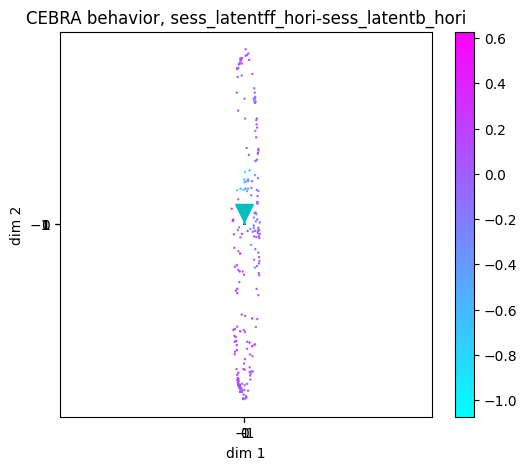

In [121]:
def plot_embedding2d_contrast(ax, embedding, label, gray = False, beh_idx=(0,1), idx_order = (0,1,2),n=20):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx[0]]-label[:, beh_idx[1]]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               c=r_c,
            #    vmin=0,
            #    vmax=1,
               cmap=r_cmap, s=0.5)
    # Create a scatter plot
    x,y,z=embedding [:,idx1],embedding [:,idx2],r_c
    width, height = 200, 300
    x *= width
    y *= height
    #create a grid on which to interpolate data
    xi, yi = np.mgrid[0:width:1j*width, 0:height:1j*height]
    #interpolate the data with the matlab griddata function
    interp = Rbf(x, y, z, function='linear')
    zi = interp(xi, yi)
    #create the contours and streamplot
    CS = plt.contour(xi, yi, zi, linewidths=1, colors='b')
    dy, dx = np.gradient(zi.T)
    plt.streamplot(xi[:,0], yi[0,:], dx, dy, color='c', density=0.1, arrowsize=3)

    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.axis('equal')
    return ax


%matplotlib inline
var1, var2=0,4 # color using var1 - var2
fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(111)
ax1=plot_embedding2d_contrast(ax1, embedding[:222], continuous_label[:222], beh_idx=[var1, var2])
ax1.set_title(f'CEBRA behavior, {thisyname[var1]}-{thisyname[var2]}')
plt.show()

# var1, var2=2,4 # color using var1 - var2
# fig = plt.figure(figsize=(6,5))
# ax1 = plt.subplot(111)
# ax1=plot_embedding2d_contrast(ax1, embedding, continuous_label, beh_idx=[var1, var2])
# ax1.set_title(f'CEBRA behavior, {thisyname[var1]}-{thisyname[var2]}')
# plt.show()
